# RESEARCH PAPER SUMMARIZER
## MEHUL GARG 
## 220968332

In [10]:
#import necessary libraries
import os
import random

import numpy as np
import pandas as pd
import regex as re
import unicodedata
import contractions
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from rouge import Rouge
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Download WordNet for NLTK
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Meta data of Dataset

In [4]:
#upload the dataset
df= pd.read_parquet("/kaggle/input/arxivdataset/validation-00000-of-00001.parquet")
df

,article,abstract
0,the interest in anchoring phenomena and phenom...,we study the phase behavior of a nematic liqui...
1,"galaxy clusters , as the largest peaks in the ...",determining the scaling relations between gala...
2,quantum correlations between components of a s...,we show how to control spatial quantum correla...
3,methanol masers are often found in star - form...,class i methanol masers are believed to be pr...
4,interdisciplinary research has recently gained...,"nowadays , scientific challenges usually requi..."
...,...,...
6431,"in the gauge theory , only the gauge invariant...",we give a formal proof that the space - time a...
6432,the stability of thin films on substrates has ...,we consider here the effects of inertia on the...
6433,density - functional theory ( dft ) @xcite is...,we introduce an orbital - optimized double - h...
6434,laser - compton scattering is an attractive me...,we have been developing optical resonant cavit...


In [5]:
# Display the number of rows and columns in the dataset
print("Dataset shape:")
print(df.shape)

Dataset shape:
(6436, 2)


In [6]:
# Check the structure of key fields: Article and Abstract
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6436 entries, 0 to 6435
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   6436 non-null   object
 1   abstract  6436 non-null   object
dtypes: object(2)
memory usage: 100.7+ KB


In [7]:
# Randomly select 5 pairs of Abstract and Title
print("Sample Article and Abstract pair:")
df[['article', 'abstract']].sample(5) 

Sample Article and Abstract pair:


,article,abstract
2299,theoretical investigations of the phase diagra...,studies of qcd lead to the hypothesis of a cri...
5509,planets form and grow in circumstellar disks ....,i calculate the spectral energy distributions ...
5000,national metrology institutes reproduce the un...,the modelling of electrical connections of sin...
5010,the question of measuring of the spatial non -...,we obtain positronium hyperfine splitting owin...
1901,with the advent of wireless technology in hand...,we develop analytical models for estimating th...


## Exploratory Analysis 

In [8]:
# Analyze the length of articles in terms of words and characters
df['article_word_count'] = df['article'].apply(lambda x: len(x.split()))
df['article_char_count'] = df['article'].apply(len)

# Analyze the length of abstracts in terms of words and characters
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.split()))
df['abstract_char_count'] = df['abstract'].apply(len)

In [9]:
# Display summary statistics
print("Summary Statistics for Articles and Abstract lengths:")
df[['article_word_count', 'article_char_count', 'abstract_word_count', 'abstract_char_count']].describe()

Summary Statistics for Articles and Abstract lengths:


,article_word_count,article_char_count,abstract_word_count,abstract_char_count
count,6436.000000,6436.000000,6436.000000,6436.000000
mean,5894.428216,32621.932101,161.539932,958.801896
std,3849.461092,21319.796747,58.453242,341.219978
min,195.000000,1094.000000,44.000000,246.000000
25%,3376.750000,18609.750000,116.000000,695.000000
50%,5029.500000,27799.000000,158.000000,936.000000
75%,7403.250000,41207.000000,205.000000,1210.250000
max,45108.000000,240296.000000,290.000000,1912.000000


In [10]:
# Check for missing or null values in Article and Abstract fields
print("Missing Values in Abstract and Title fields:")
print(df[['article', 'abstract']].isnull().sum())

Missing Values in Abstract and Title fields:
article     0
abstract    0
dtype: int64


In [11]:
# Check for extremely short abstracts or titles
min_article_length = 500  # Set minimum acceptable length for abstracts
min_abstract_length = 50  # Set minimum acceptable length for titles 

short_articles= df[df['article_word_count'] < min_article_length]
short_abstracts = df[df['abstract_word_count'] < min_abstract_length]

print(f"Number of articles with fewer than {min_article_length} words: {len(short_articles)}")
print(f"Number of abstracts with fewer than {min_abstract_length} words: {len(short_abstracts)}")

Number of articles with fewer than 500 words: 19
Number of abstracts with fewer than 50 words: 36


In [12]:
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']

# Create a new column for the word count category
df['abstract_word_category'] = pd.cut(df['abstract_word_count'], bins=bins, labels=labels, right=False)

# Count the number of abstracts in each category
word_count_summary = df['abstract_word_category'].value_counts().sort_index()

print(word_count_summary)

abstract_word_category
0-50         36
50-100     1017
100-150    1865
150-200    1748
200-250    1171
250-300     599
Name: count, dtype: int64


In [13]:
# Check for duplicate records based on PaperId or identical Abstract-Title pairs
print("Duplicate based on Abstract-Title pairs:", df.duplicated(subset=['article', 'abstract']).sum())

Duplicate based on Abstract-Title pairs: 0


In [14]:
# Remove duplicates if necessary
df = df.drop_duplicates(subset=['article', 'abstract'])  # Remove based on Abstract-Title pairs

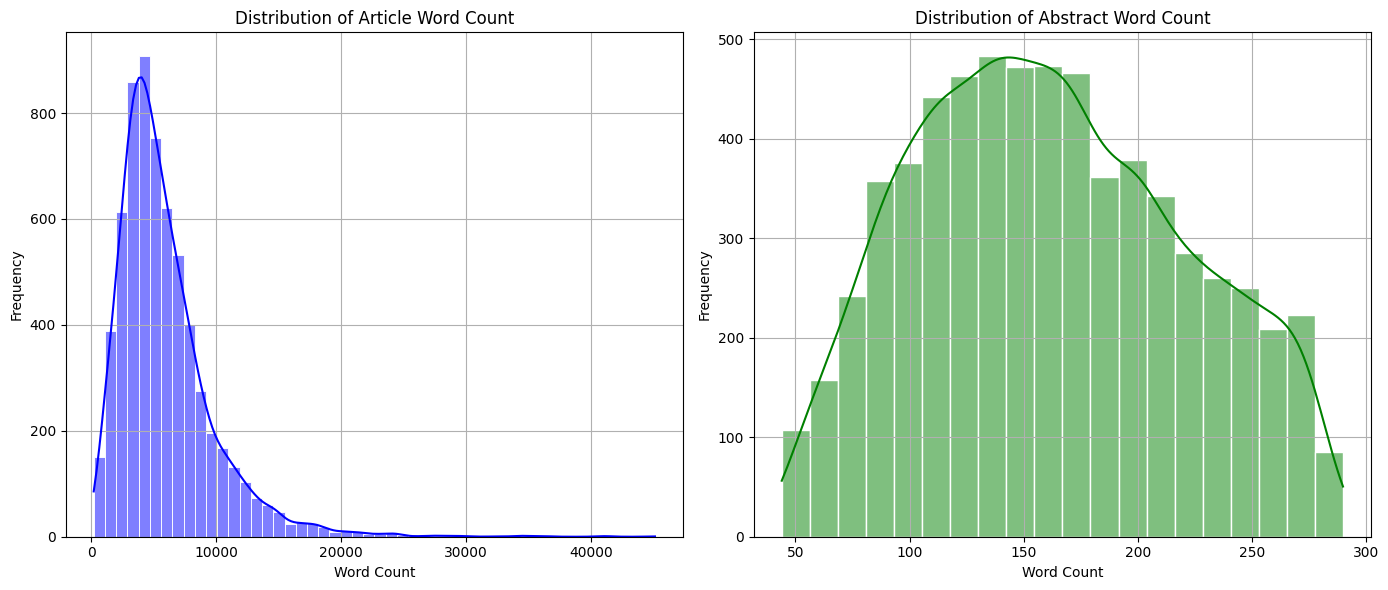

In [15]:
# Plot distribution of Article and Abstract lengths (word count)
plt.figure(figsize=(14, 6))
# Abstract word count distribution
plt.subplot(1, 2, 1)
sns.histplot(df['article_word_count'], bins=50, kde=True, color='blue',edgecolor='white')
plt.grid(True)
plt.title('Distribution of Article Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Title word count distribution
plt.subplot(1, 2, 2)
sns.histplot(df['abstract_word_count'], bins=20, kde=True, color='green',edgecolor='white')
plt.grid(True)
plt.title('Distribution of Abstract Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

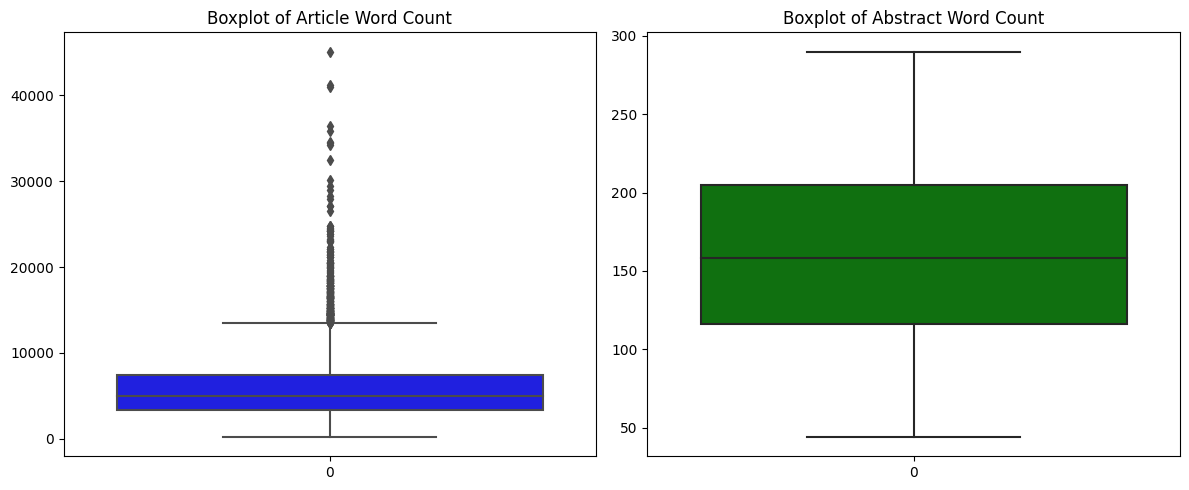

In [16]:
# Boxplot to detect outliers in Abstract and Title lengths
plt.figure(figsize=(12, 5))

# Abstract length boxplot
plt.subplot(1, 2, 1)
sns.boxplot(df['article_word_count'], color='blue')
plt.title('Boxplot of Article Word Count')

# Title length boxplot
plt.subplot(1, 2, 2)
sns.boxplot(df['abstract_word_count'], color='green')
plt.title('Boxplot of Abstract Word Count')

plt.tight_layout()
plt.show()

# Preprocessing pipeline specific to data 

In [17]:
# Cleans and preprocesses the input text for further analysis.
def clean_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = contractions.fix(text)
    text = re.sub(r'_+', '', text)
    return text.strip()

In [18]:
df['clean_article'] = df['article'].apply(clean_text)
df['clean_abstract'] = df['abstract'].apply(clean_text)

In [19]:
# Function to count words in an abstract
def word_count(text):
    return len(text.split()) if isinstance(text, str) else 0

# Apply the word count function to the 'abstract' column
df['abstract_word_count'] = df['clean_abstract'].apply(word_count)

# Define the bins
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']

# Create a new column for the word count category
df['abstract_word_category'] = pd.cut(df['abstract_word_count'], bins=bins, labels=labels, right=False)

# Count the number of abstracts in each category
word_count_summary = df['abstract_word_category'].value_counts().sort_index()

print(word_count_summary)


abstract_word_category
0-50         93
50-100     1393
100-150    2205
150-200    1700
200-250     996
250-300      49
Name: count, dtype: int64


# Pre-trained models

In [20]:
def evaluate_model(common_model_name, actual_model_name, df, batch_size=5):
    # Create a smoothing function
    smoothing_function = SmoothingFunction()

    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(actual_model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(actual_model_name).to('cuda')
    model.gradient_checkpointing_enable()  # Enable gradient checkpointing

    # Filter for abstracts in the 250-300 word category
    filtered_df = df[df['abstract_word_category'] == '200-250']
    sampled_rows = filtered_df.sample(n=996, random_state=42)

    # Initialize cumulative scores
    total_bleu = 0
    total_rouge_1 = 0
    total_rouge_2 = 0
    total_rouge_l = 0
    num_summaries = 0
    rouge = Rouge()

    for i in tqdm(range(0, len(sampled_rows), batch_size)):
        texts = sampled_rows["article"].iloc[i:i + batch_size].tolist()
        actual_summaries = sampled_rows["abstract"].iloc[i:i + batch_size].tolist()

        inputs = tokenizer(texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to('cuda')

        with torch.amp.autocast(device_type='cuda'):
            summary_ids = model.generate(inputs['input_ids'], max_length=275, min_length=175, length_penalty=1.0, num_beams=2, early_stopping=True)

        summaries = [tokenizer.decode(sid, skip_special_tokens=True) for sid in summary_ids]
        torch.cuda.empty_cache()  # Clear cache after processing

        for actual_summary, summary in zip(actual_summaries, summaries):
            reference = [actual_summary.split()]
            candidate = summary.split()
            bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function.method1)

            scores = rouge.get_scores(summary, actual_summary)[0]
            
            # Accumulate scores
            total_bleu += bleu_score
            total_rouge_1 += scores['rouge-1']['f']
            total_rouge_2 += scores['rouge-2']['f']
            total_rouge_l += scores['rouge-l']['f']
            num_summaries += 1

    # Calculate final scores
    final_bleu = total_bleu / num_summaries
    final_rouge_1 = total_rouge_1 / num_summaries
    final_rouge_2 = total_rouge_2 / num_summaries
    final_rouge_l = total_rouge_l / num_summaries

    # Create a Series to hold the final scores
    scores_series = pd.Series({
        'Model': common_model_name,
        'Final BLEU Score': final_bleu,
        'Final ROUGE-1': final_rouge_1,
        'Final ROUGE-2': final_rouge_2,
        'Final ROUGE-L': final_rouge_l,
    })

    return scores_series

In [21]:
# Initialize an empty DataFrame
results_df = pd.DataFrame()  

# Call the function for different models
common_model_names = ["Fine Tuned BART", "Fine Tuned distilBART","Pegasus","BART"]
actual_model_names = [
    "JustinDu/BARTxiv", 
    "WasibMehmood/TextSummizer",
    "google/pegasus-large",
    "facebook/bart-large"
]

for common_name, actual_name in zip(common_model_names, actual_model_names):
    scores = evaluate_model(common_name, actual_name, df)
    
    # Convert scores to DataFrame if it's not already
    scores_df = pd.DataFrame([scores])  # Assuming scores is a dict
    results_df = pd.concat([results_df, scores_df], ignore_index=True)

results_df

tokenizer_config.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

100%|██████████| 200/200 [17:44<00:00,  5.32s/it]


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

100%|██████████| 200/200 [09:21<00:00,  2.81s/it]


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

100%|██████████| 200/200 [21:50<00:00,  6.55s/it]


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

100%|██████████| 200/200 [20:28<00:00,  6.14s/it]


,Model,Final BLEU Score,Final ROUGE-1,Final ROUGE-2,Final ROUGE-L
0,Fine Tuned BART,0.055871,0.336750,0.113000,0.294289
1,Fine Tuned distilBART,0.031865,0.305717,0.094207,0.268880
2,Pegasus,0.042347,0.307075,0.092487,0.259921
3,BART,0.052583,0.298987,0.090948,0.259226


# Visualization of performance of pre-trained models. 

<Figure size 1200x600 with 0 Axes>

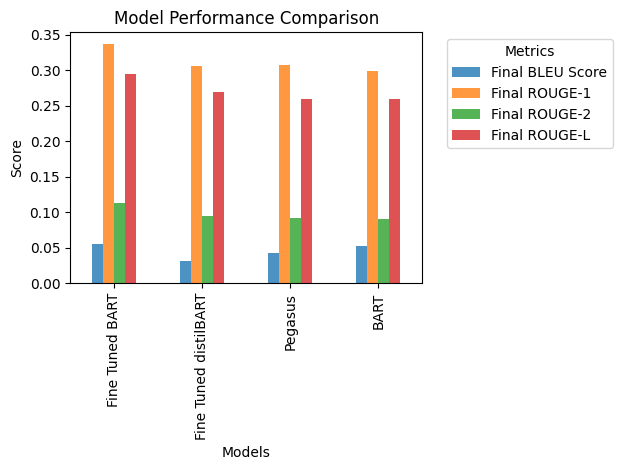

In [22]:
# Bar plot for metrics
plt.figure(figsize=(12, 6))
results_df.set_index('Model').plot(kind='bar', alpha=0.8)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=90)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Training LSTM Model
#### NOTE: Due to memory constraints LSTM model is trained and saved. Later the saved model is called and has to be implemented on a subset of the dataset. 

In [7]:
# Load your data
df = pd.read_parquet('/kaggle/input/arxivdataset/validation-00000-of-00001.parquet')  
df

,article,abstract
0,the interest in anchoring phenomena and phenom...,we study the phase behavior of a nematic liqui...
1,"galaxy clusters , as the largest peaks in the ...",determining the scaling relations between gala...
2,quantum correlations between components of a s...,we show how to control spatial quantum correla...
3,methanol masers are often found in star - form...,class i methanol masers are believed to be pr...
4,interdisciplinary research has recently gained...,"nowadays , scientific challenges usually requi..."
...,...,...
6431,"in the gauge theory , only the gauge invariant...",we give a formal proof that the space - time a...
6432,the stability of thin films on substrates has ...,we consider here the effects of inertia on the...
6433,density - functional theory ( dft ) @xcite is...,we introduce an orbital - optimized double - h...
6434,laser - compton scattering is an attractive me...,we have been developing optical resonant cavit...


In [8]:
max_words = 50000
max_len_article = 9743  
max_len_abstract = 219    

In [11]:
#Tokenizes and pads article texts for neural network input.

article_tokenizer = Tokenizer(num_words=max_words)
article_tokenizer.fit_on_texts(df['article'])
article_sequences = article_tokenizer.texts_to_sequences(df['article'])
article_padded = pad_sequences(article_sequences, maxlen=max_len_article, padding='post')

In [12]:
#Tokenizes and pads abstracts texts for neural network input.

abstract_tokenizer = Tokenizer(num_words=max_words)
abstract_tokenizer.fit_on_texts(df['abstract'])
abstract_squences = abstract_tokenizer.texts_to_sequences(df['abstract'])
abstract_padded = pad_sequences(abstract_squences, maxlen=max_len_abstract, padding='post')

In [13]:
num_words_article = len(article_tokenizer.word_index) + 1
num_words_abstract = len(abstract_tokenizer.word_index) + 1

In [14]:
#Split data into train, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(article_padded, abstract_padded, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# Encoder-Decoder Model

# Encoder
encoder_inputs = Input(shape=(max_len_article,))
encoder_embedding = Embedding(input_dim=num_words_article, output_dim=128, input_length=max_len_article)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_len_abstract,))
decoder_embedding = Embedding(input_dim=num_words_abstract, output_dim=128, input_length=max_len_abstract)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Dense layer to generate final summary
decoder_dense = Dense(num_words_abstract, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
decoder_target_data_train = np.expand_dims(y_train, -1)
decoder_target_data_val = np.expand_dims(y_val, -1)

In [22]:
history = model.fit([X_train, y_train], decoder_target_data_train, 
          validation_data=([X_val, y_val], decoder_target_data_val), 
          epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 81s 765ms/step - loss: 7.1546 - val_loss: 4.7731
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 810ms/step - loss: 4.5587 - val_loss: 4.1742
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 813ms/step - loss: 4.0823 - val_loss: 3.8031
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 815ms/step - loss: 3.6825 - val_loss: 3.4855
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 813ms/step - loss: 3.3868 - val_loss: 3.2112
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 815ms/step - loss: 3.0730 - val_loss: 2.8821
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 816ms/step - loss: 2.7116 - val_loss: 2.4915
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 816ms/step - loss: 2.3207 - val_loss: 2.0904
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 816ms/step - loss: 1.9094 - val_loss: 1.7548
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 817ms/step - loss: 1.5862 - val_loss: 1.4931
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 83s 819ms/step - loss: 1.3595 - val_loss: 1.2939
Epoch 12

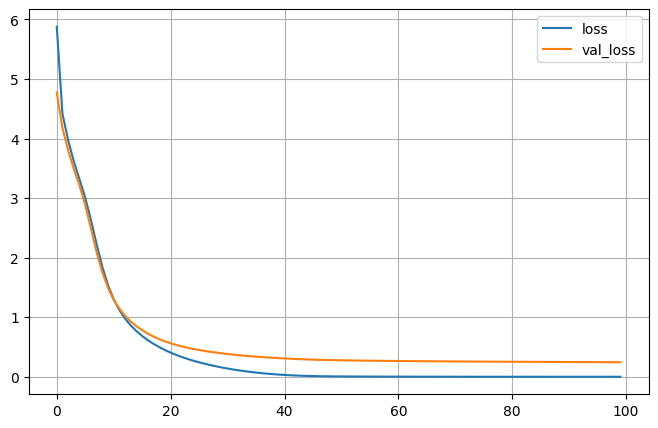

In [23]:
import matplotlib.pyplot as plt 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [25]:
#Split the dataset into train, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(article_padded, abstract_padded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [26]:
#Predict on test set
predictions = model.predict([X_test, y_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step


In [29]:
def decode_sequence(sequence, tokenizer):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = ' '.join([reverse_word_map.get(i, '') for i in sequence])
    return decoded_text.strip()

In [30]:
bleu_scores = []
rouge = Rouge()
rouge_scores = []

In [31]:
for i in range(len(X_test)):
    # Get the true abstract and predicted abstract
    true_abstract = decode_sequence(y_test[i], abstract_tokenizer)
    predicted_abstract = decode_sequence(np.argmax(predictions[i], axis=-1), abstract_tokenizer)
    
    # Calculate BLEU score
    reference = [true_abstract.split()]
    candidate = predicted_abstract.split()
    bleu_score = sentence_bleu(reference, candidate)
    bleu_scores.append(bleu_score)
    
    # Calculate ROUGE score
    rouge_score = rouge.get_scores(predicted_abstract, true_abstract)
    rouge_scores.append(rouge_score)

In [32]:
#View random predicted abstract
print(decode_sequence(np.argmax(predictions[126], axis=-1), abstract_tokenizer))

we present calculations of structural and magnetic properties of the iron  superconductor  including electron electron correlations for this purpose we apply a fully charge self consistent combination of density functional theory with the dynamical mean field theory allowing for the calculation of total energies we find that the inclusion of correlation effects gives a good agreement of the  xmath0 position with experimental data even in the paramagnetic high temperature phase going to low temperatures we study the formation of the ordered moment in the  spin density wave phase yielding an ordered moment of about xmath1 xmath2 again in good agreement with experiments this shows that the inclusion of correlation effects improves both structural and magnetic properties of  at the same time


In [33]:
#View actual abstract
print(decode_sequence(y_test[126], abstract_tokenizer))

we present calculations of structural and magnetic properties of the iron pnictide superconductor lafeaso including electron electron correlations for this purpose we apply a fully charge self consistent combination of density functional theory with the dynamical mean field theory allowing for the calculation of total energies we find that the inclusion of correlation effects gives a good agreement of the arsenic xmath0 position with experimental data even in the paramagnetic high temperature phase going to low temperatures we study the formation of the ordered moment in the striped spin density wave phase yielding an ordered moment of about xmath1 xmath2 again in good agreement with experiments this shows that the inclusion of correlation effects improves both structural and magnetic properties of lafeaso at the same time


In [34]:
#Calculate average bleu score
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")

Average BLEU Score: 0.9291410421793171


In [35]:
#Calculate average rouge score
average_rouge = {
    'rouge-1': np.mean([score[0]['rouge-1']['f'] for score in rouge_scores]),
    'rouge-2': np.mean([score[0]['rouge-2']['f'] for score in rouge_scores]),
    'rouge-l': np.mean([score[0]['rouge-l']['f'] for score in rouge_scores])
}
print(f"Average ROUGE Scores: {average_rouge}")

Average ROUGE Scores: {'rouge-1': 0.9794156561313324, 'rouge-2': 0.9556702442908018, 'rouge-l': 0.9794156561313324}


## Visualizing performance of all 5 models. 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

data = [
    ['Fine Tuned BART', 0.055871, 0.336750, 0.113000, 0.294289],
    ['Fine Tuned distilBART', 0.031865, 0.305717, 0.094207, 0.268880],
    ['Pegasus', 0.042347, 0.307075, 0.092487, 0.259921],
    ['BART', 0.052583, 0.289987, 0.090948, 0.259226],
    ['LSTM Model', 0.929141, 0.979415, 0.955670, 0.979415]
]

columns = ['Model', 'Final BLEU Score', 'Final ROUGE-1', 'Final ROUGE-2', 'Final ROUGE-L']
df = pd.DataFrame(data, columns=columns).set_index('Model')
df

,Final BLEU Score,Final ROUGE-1,Final ROUGE-2,Final ROUGE-L
Model,,,,
Fine Tuned BART,0.055871,0.336750,0.113000,0.294289
Fine Tuned distilBART,0.031865,0.305717,0.094207,0.268880
Pegasus,0.042347,0.307075,0.092487,0.259921
BART,0.052583,0.289987,0.090948,0.259226
LSTM Model,0.929141,0.979415,0.955670,0.979415


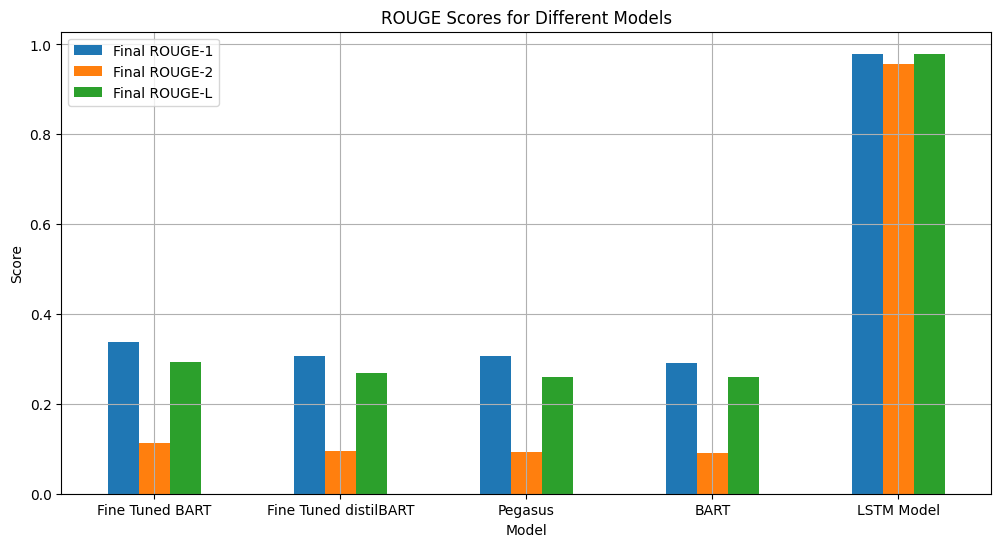

In [49]:

# Plot the ROUGE scores
fig, ax = plt.subplots(figsize=(12, 6))
df[['Final ROUGE-1', 'Final ROUGE-2', 'Final ROUGE-L']].plot(kind='bar', ax=ax)
ax.set_title('ROUGE Scores for Different Models')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.xticks(rotation=0)
ax.grid(True)
plt.show()